In [ ]:
import pandas
import zipfile
import json
import numpy

from scipy.optimize import minimize
from matplotlib import pyplot as plt


fns = {
    "exc-only": "./download-exc_only.zip",
    "inh-prox": "./download-inh_prox.zip",
    "inh-dist": "./download-inh_dist.zip"
}
freq_e_used = 5

f_zip = dict([
    (k, zipfile.ZipFile(v))
    for k, v in fns.items()
])

## Read in data

In [2]:
data_keys = ["x", "y"]

def entries_to_df(entries):
    data = []    
    for entry in entries:
        df = pandas.DataFrame(dict([(k, entry.pop(k)) for k in data_keys]))
        for k, v in entry.items():
            df[k] = v
        data.append(df)
    ret = pandas.concat(data, axis=0)
    cols = [_c for _c in ret.columns if _c not in data_keys]
    ret = ret.fillna("_NONE").set_index(cols)
    return ret

def read_list_of_entries(lst):
    data = pandas.concat([entries_to_df(_v) for _v in lst.values()], axis=0)
    return data

def read_sim_config_data(fid):
    cfg = json.load(fid)
    data_out = read_list_of_entries(cfg["simulation"])
    stim_out = entries_to_df(cfg["stimulus"])
    return data_out, stim_out

def read_all_contents(f_zip):
    all_data = []; all_stim = []
    for fn in f_zip.filelist:
        with f_zip.open(fn) as fid:
            data, stim = read_sim_config_data(fid)
            all_data.append(data); all_stim.append(stim)
    all_stim = pandas.concat(all_stim, axis=0, keys=range(len(all_stim)), names=["repetition"])
    all_data = pandas.concat(all_data, axis=0, keys=range(len(all_data)), names=["repetition"])
    return (all_stim, all_data)

contents = dict([
    (k, read_all_contents(v))
    for k, v in f_zip.items()
])


## Perform simple spike counting

In [3]:
def simple_spike_counter(stim_rec_tuple):
    _, rec_df = stim_rec_tuple
    # This simple spike counter simply detects crossing 0 mV.
    zero_crossings = (rec_df["y"].values[:-1] < 0) & (rec_df["y"].values[1:] >= 0)
    t_spikes = rec_df["x"].iloc[1:][zero_crossings]
    t_spikes.name = "spike-count"

    return t_spikes.groupby(t_spikes.index.names).count()

spike_counts = dict([
    (k, simple_spike_counter(v))
    for k, v in contents.items()
])

## Focus on conditions of interest and reformat data representation

In [4]:
cols_to_drop = ["type", "name", "recording", "varying_key"]
cols_of_interest = ["amplitude", "freq-e", "freq-i-prox", "freq-i-dist"]

df = spike_counts["exc-only"].reset_index()
df = df.drop(columns=cols_to_drop).rename(columns={"frequency": "freq-e"})
df["freq-i-prox"] = 0
df["freq-i-dist"] = 0
spike_counts["exc-only"] = df

df = spike_counts["inh-prox"].reset_index()
df = df.drop(columns=cols_to_drop).rename(columns={"frequency": "freq-i-prox"})
df["freq-e"] = freq_e_used
df["freq-i-dist"] = 0
spike_counts["inh-prox"] = df

df = spike_counts["inh-dist"].reset_index()
df = df.drop(columns=cols_to_drop).rename(columns={"frequency": "freq-i-dist"})
df["freq-e"] = freq_e_used
df["freq-i-prox"] = 0
spike_counts["inh-dist"] = df

/var/folders/py/wqmt8l2s5zb8fhrxbd_b258w0000gn/T/ipykernel_44261/3358423807.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  plt.plot(spike_count_df_ro[(0, 0, 0)], marker='o', label="Excitation only")


'The black arrow indicates the excitatory frequency used for the second plot.'

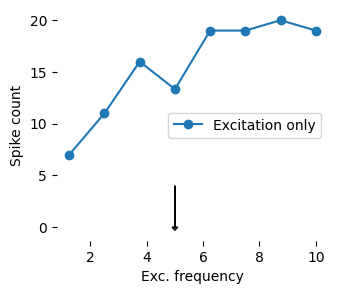

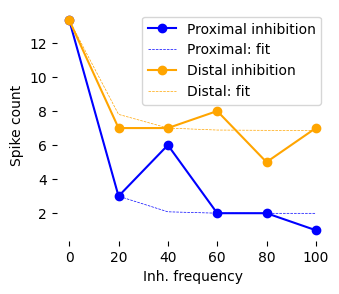

In [15]:
spike_count_df = pandas.concat(list(spike_counts.values()), axis=0)

spike_count_df = spike_count_df.groupby(cols_of_interest)["spike-count"].mean()
spike_count_df_ro = spike_count_df.reorder_levels(["amplitude", "freq-i-prox", "freq-i-dist", "freq-e"])

plt.figure(figsize=(3.5, 3.))
plt.plot(spike_count_df_ro[(0, 0, 0)], marker='o', label="Excitation only")
plt.arrow(freq_e_used, 4, 0, -4, head_width=0.2)
plt.legend()
plt.gca().set_xlabel("Exc. frequency")
plt.gca().set_ylabel("Spike count")
plt.gca().set_frame_on(False)

plt.figure(figsize=(3.5, 3.))

data = spike_count_df[(0, freq_e_used)].unstack("freq-i-dist")[0]
x = data.index.values; y = data.values
plt.plot(x, y, marker='o', label="Proximal inhibition", color="blue")
fit_fun = lambda _param: (y[0] - _param[1]) * numpy.exp(-x / _param[0]) + _param[1]
opt_fun = lambda _param: numpy.sum(numpy.abs(fit_fun(_param) - y))
opt_res = minimize(opt_fun, [10.0, 1.0]).x
plt.plot(x, fit_fun(opt_res), color="blue", ls="--", lw=0.5, label="Proximal: fit")

data = spike_count_df[(0, freq_e_used)].unstack("freq-i-prox")[0]
x = data.index.values; y = data.values
plt.plot(x, y, marker='o', label="Distal inhibition", color="orange")
fit_fun = lambda _param: (y[0] - _param[1]) * numpy.exp(-x / _param[0]) + _param[1]
opt_fun = lambda _param: numpy.sum(numpy.abs(fit_fun(_param) - y))
opt_res = minimize(opt_fun, [10.0, 1.0]).x
plt.plot(x, fit_fun(opt_res), color="orange", ls="--", lw=0.5, label="Distal: fit")

plt.legend()
plt.gca().set_xlabel("Inh. frequency")
plt.gca().set_ylabel("Spike count")
plt.gca().set_frame_on(False)

display("The black arrow indicates the excitatory frequency used for the second plot.")

In [6]:
data = spike_count_df[(0, freq_e_used)].unstack("freq-i-dist")[0]

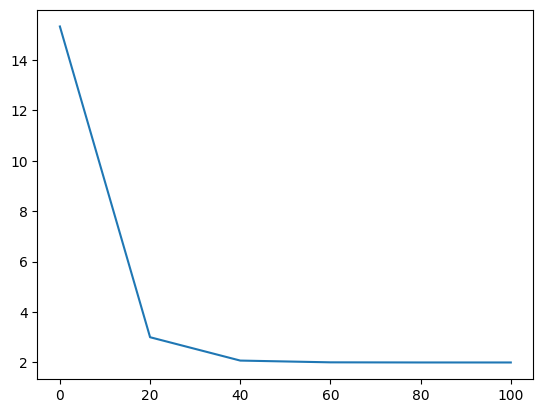

In [ ]:


x = data.index.values; y = data.values
fit_fun = lambda _param: y[0] * numpy.exp(-x / _param[0]) + _param[1]
opt_fun = lambda _param: numpy.sum(numpy.abs(fit_fun(_param) - y))
opt_res = minimize(opt_fun, [10.0, 1.0]).x
plt.plot(x, fit_fun(opt_res))
